In [78]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import copy

In [79]:
rows = 5
cols = 8
gamma = 0.99
noise = 0.1
big_penalty = -1000
goal_reward = 1000

# hazards
hazards = [(0, 0), (0, 4)]

# goal
goal = (0, 2)

# starting positions - s1 through s7 along bottom row
starts = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0)]

In [80]:
dirs = {
    'N': (0, 1),
    'S': (0, -1),
    'E': (1, 0),
    'W': (-1, 0),
    'NE': (1, 1),
    'NW': (-1, 1),
    'SE': (1, -1),
    'SW': (-1, -1)
}

dir_names = ['N', 'S', 'E', 'W', 'NE', 'NW', 'SE', 'SW']

In [81]:
# get allowed moves
def get_moves(intended):
    if intended == 'N':
        return ['N', 'NE', 'NW']
    elif intended == 'S':
        return ['S', 'SE', 'SW']
    elif intended == 'E':
        return ['E', 'NE', 'SE']
    elif intended == 'W':
        return ['W', 'NW', 'SW']
    elif intended == 'NE':
        return ['NE', 'N', 'E']
    elif intended == 'NW':
        return ['NW', 'N', 'W']
    elif intended == 'SE':
        return ['SE', 'S', 'E']
    elif intended == 'SW':
        return ['SW', 'S', 'W']
    return []

# check if position valid
def valid_pos(x, y, obstacles=[]):
    if x < 0 or x >= cols or y < 0 or y >= rows:
        return False
    if (x, y) in obstacles:
        return False
    return True

# get next state given current state and action
def nxt_state(x, y, action, obstacles=[]):
    dx, dy = dirs[action]
    nx, ny = x + dx, y + dy
    if valid_pos(nx, ny, obstacles):
        return (nx, ny)
    return (x, y)

# get transition probabilities for intended action
def trans_prob(x, y, intended, obstacles=[]):
    probs = {}
    moves = get_moves(intended)

    if not moves:
        return probs

    n_unintended = len(moves) - 1

    for mv in moves:
        ns = nxt_state(x, y, mv, obstacles)
        if mv == intended:
            p = 1 - noise
        else:
            p = noise / n_unintended if n_unintended > 0 else 0

        if ns in probs:
            probs[ns] += p
        else:
            probs[ns] = p

    return probs

# get reward for a state
def get_reward(x, y, live_in_r):
    if (x, y) == goal:
        return goal_reward
    elif (x, y) in hazards:
        return big_penalty
    else:
        return live_in_r

In [82]:
def val_iter(live_in_r, obstacles=[], max_iter=1000, thresh=0.01):
    V = np.zeros((cols, rows))
    policy = {}

    for x in range(cols):
        for y in range(rows):
            if (x, y) in hazards:
                V[x, y] = big_penalty
            elif (x, y) == goal:
                V[x, y] = goal_reward

    for iteration in range(max_iter):
        V_old = V.copy()
        delta = 0

        for x in range(cols):
            for y in range(rows):
                if (x, y) == goal or (x, y) in hazards:
                    continue

                if not valid_pos(x, y, obstacles):
                    continue

                max_val = float('-inf')
                best_act = None

                for intended in dir_names:
                    val = 0
                    t_probs = trans_prob(x, y, intended, obstacles)

                    for (nx, ny), prob in t_probs.items():
                        r = get_reward(nx, ny, live_in_r)
                        val += prob * (r + gamma * V_old[nx, ny])

                    if val > max_val:
                        max_val = val
                        best_act = intended

                V[x, y] = max_val
                policy[(x, y)] = best_act
                delta = max(delta, abs(V[x, y] - V_old[x, y]))

        if delta < thresh:
            break

    return V, policy

In [83]:
# check if policy leads to goal from all starts
def check_policy(policy, obstacles=[]):
    for start in starts:
        # skip if start is a hazard or goal
        if start in hazards or start == goal:
            continue

        pos = start
        visited = set()
        steps = 0
        max_steps = 100

        while pos != goal and steps < max_steps:
            if pos in visited:
                return False
            visited.add(pos)

            if pos not in policy:
                return False

            action = policy[pos]
            pos = nxt_state(pos[0], pos[1], action, obstacles)
            steps += 1

        if pos != goal:
            return False

    return True

In [84]:
# visualize policy with arrows
def viz_policy(policy, obstacles, title_txt):
    fig, ax = plt.subplots(figsize=(12, 7))

    for x in range(cols):
        for y in range(rows):
            rect = Rectangle((x, y), 1, 1, fill=False, edgecolor='gray', linewidth=0.8)
            ax.add_patch(rect)

    for haz in hazards:
        rect = Rectangle((haz[0], haz[1]), 1, 1, fill=True, facecolor='red', alpha=0.4)
        ax.add_patch(rect)
        ax.text(haz[0] + 0.5, haz[1] + 0.5, '-R', ha='center', va='center',
               fontsize=10, fontweight='bold', color='white')

    for obs in obstacles:
        if obs not in hazards:
            rect = Rectangle((obs[0], obs[1]), 1, 1, fill=True, facecolor='black', alpha=0.7)
            ax.add_patch(rect)

    rect = Rectangle((goal[0], goal[1]), 1, 1, fill=True, facecolor='green', alpha=0.5)
    ax.add_patch(rect)
    ax.text(goal[0] + 0.5, goal[1] + 0.5, '+R', ha='center', va='center',
           fontsize=10, fontweight='bold', color='white')

    for (x, y), action in policy.items():
        if (x, y) == goal or (x, y) in hazards:
            continue

        dx, dy = dirs[action]
        scale = 0.3
        ax.arrow(x + 0.5, y + 0.5, dx * scale, dy * scale,
                head_width=0.12, head_length=0.08, fc='blue', ec='blue', linewidth=1.8)

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect('equal')
    ax.set_xticks(range(cols + 1))
    ax.set_yticks(range(rows + 1))
    ax.grid(True, linewidth=0.4, alpha=0.6)
    ax.set_xlabel('Column', fontsize=11)
    ax.set_ylabel('Row', fontsize=11)
    ax.set_title(title_txt, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# display value function as grid
def show_values(V, title_txt):
    fig, ax = plt.subplots(figsize=(12, 7))

    for x in range(cols):
        for y in range(rows):
            val = V[x, y]
            color = 'white'
            if (x, y) in hazards:
                color = 'lightcoral'
            elif (x, y) == goal:
                color = 'lightgreen'

            rect = Rectangle((x, y), 1, 1, fill=True, facecolor=color,
                           edgecolor='black', linewidth=0.8, alpha=0.4)
            ax.add_patch(rect)

            ax.text(x + 0.5, y + 0.5, f'{val:.0f}',
                   ha='center', va='center', fontsize=7, fontweight='bold')

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect('equal')
    ax.set_xticks(range(cols + 1))
    ax.set_yticks(range(rows + 1))
    ax.grid(True, linewidth=0.4, alpha=0.6)
    ax.set_xlabel('Column', fontsize=11)
    ax.set_ylabel('Row', fontsize=11)
    ax.set_title(title_txt, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [85]:

print("R1: ORIGINAL ENVIRONMENT")

# r1a - find optimal live-in reward
obstacles_r1 = hazards.copy()
best_r = None

for r in range(-20, 1):
    V, pol = val_iter(r, obstacles_r1)
    if check_policy(pol, obstacles_r1):
        best_r = r
        best_V_r1 = V
        best_pol_r1 = pol
        break

print(f"\nR1(a) - Optimal Live-In Reward: {best_r}")
print()


R1: ORIGINAL ENVIRONMENT

R1(a) - Optimal Live-In Reward: -20



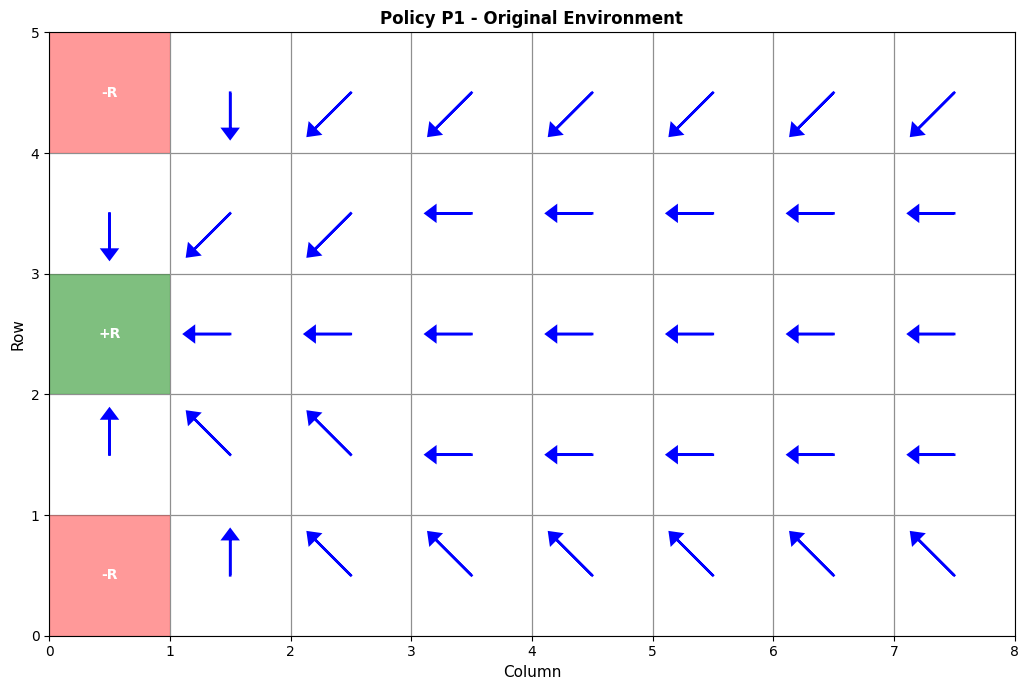

In [86]:
# r1b - visualize policy p1 with arrows
viz_policy(best_pol_r1, obstacles_r1, "Policy P1 - Original Environment")

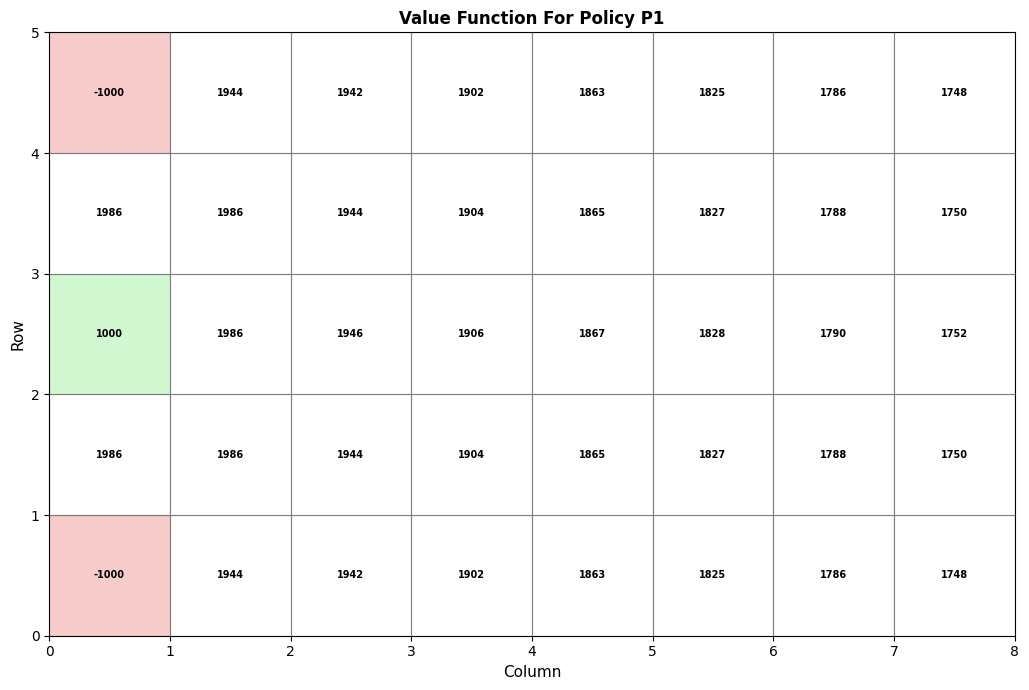

In [87]:
# r1b - display value function for p1
show_values(best_V_r1, "Value Function For Policy P1")

In [88]:
print("R2: ENVIRONMENT WITH OBSTACLE")

# r2 - add obstacle at position (3,4)
obstacles_r2 = hazards + [(3, 2)]
best_r_r2 = None

for r in range(-20, 1):
    V, pol = val_iter(r, obstacles_r2)
    if check_policy(pol, obstacles_r2):
        best_r_r2 = r
        best_V_r2 = V
        best_pol_r2 = pol
        break

print(f"\nR2 - Optimal Live-In Reward With Obstacle: {best_r_r2}")
print()

R2: ENVIRONMENT WITH OBSTACLE

R2 - Optimal Live-In Reward With Obstacle: -20



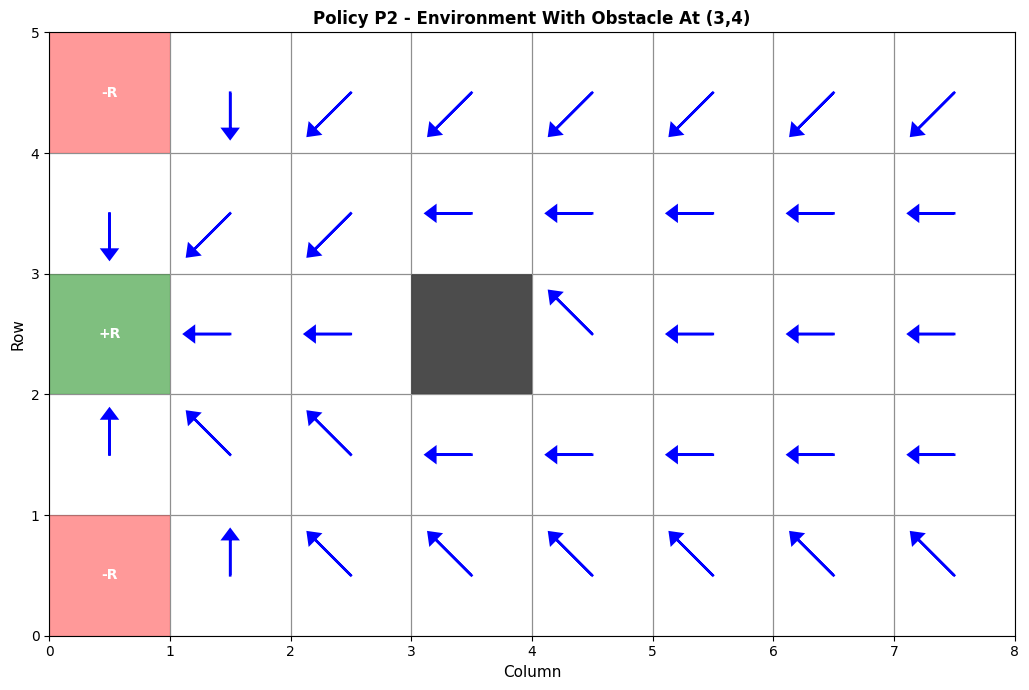

In [89]:
# r2 - visualize policy p2 with arrows
viz_policy(best_pol_r2, obstacles_r2, "Policy P2 - Environment With Obstacle At (3,4)")

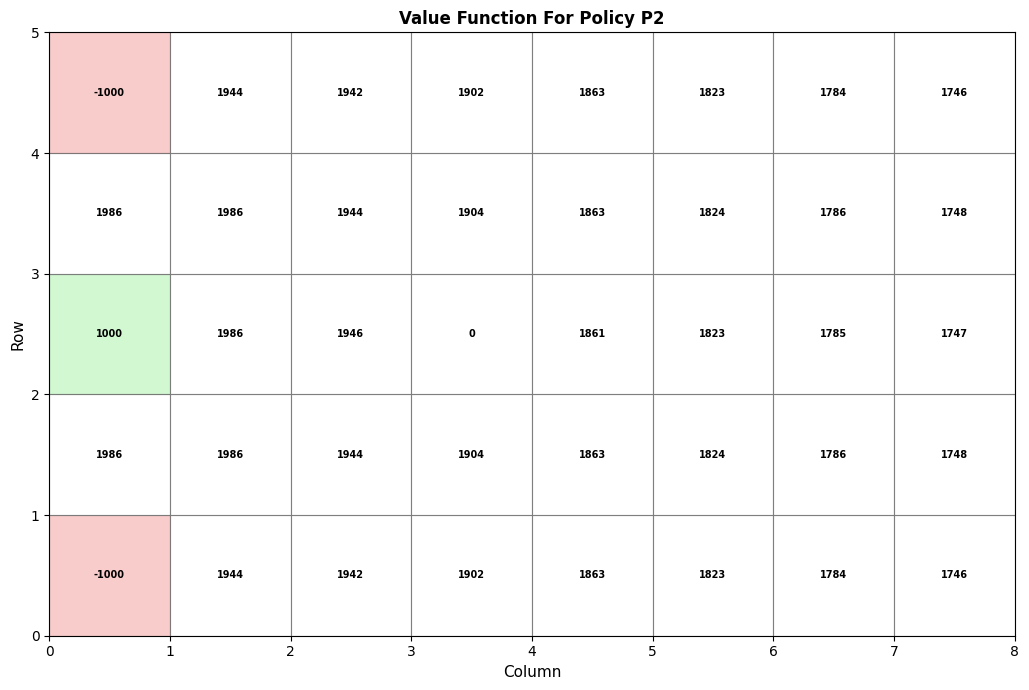

In [90]:
# r2 - display value function for p2
show_values(best_V_r2, "Value Function For Policy P2")

In [91]:
# compare policies p1 and p2
def compare_pols(pol1, pol2):
    diff_count = 0
    diffs = []

    all_pos = set(pol1.keys()).union(set(pol2.keys()))

    for pos in all_pos:
        act1 = pol1.get(pos, None)
        act2 = pol2.get(pos, None)

        if act1 != act2:
            diff_count += 1
            diffs.append((pos, act1, act2))

    return diff_count, diffs

diff_cnt, diff_list = compare_pols(best_pol_r1, best_pol_r2)

print("R2: POLICY COMPARISON BETWEEN P1 AND P2")
print(f"\nNumber of differences: {diff_cnt}")
if diff_cnt > 0:
    print(f"\nPositions where policies differ:")
    for pos, a1, a2 in sorted(diff_list):
        print(f"  Position {pos}: P1 action={a1}, P2 action={a2}")
else:
    print("\nPolicies are identical")

R2: POLICY COMPARISON BETWEEN P1 AND P2

Number of differences: 2

Positions where policies differ:
  Position (3, 2): P1 action=W, P2 action=None
  Position (4, 2): P1 action=W, P2 action=NW
